# Polscope with phase/inclination forward simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 256                 # number of pixel in y dimension
M           = 256                 # number of pixel in x dimension
mag         = 40                  # magnification
ps          = 6.5/mag             # effective pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 0.55              # objective NA
NA_illu     = 0.55                 # illumination NA (condenser)
# z_defocus   = (np.r_[:5]-2)*1.757 # a set of defocus plane
z_defocus   = np.array([0])
chi         = 0.25*2*np.pi           # swing of Polscope analyzer


### Sample creation

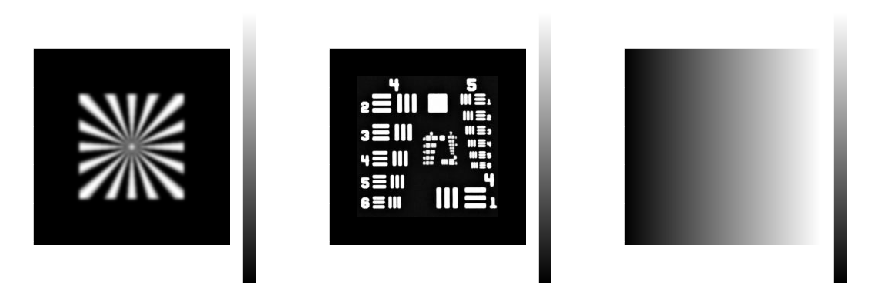

In [3]:

# generate Siemens star target

star, theta, xx = wo.genStarTarget(N,M)

xx = xx/np.max(xx)

# Load res_target
res_target = np.double(plt.imread('resolution.jpg'))
res_target = res_target[322:506,357:541,1]
res_target = np.pad(res_target/np.max(res_target),36,mode='constant')


wo.plot_multicolumn(np.array([star, res_target, xx]), num_col=3, size=5)

In [4]:
0.3/2/np.pi*532

25.401128917466494

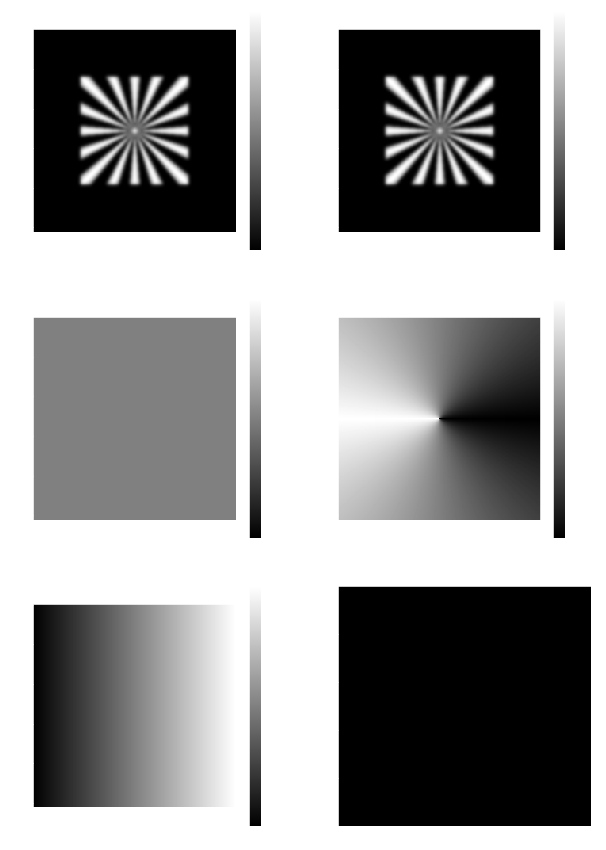

In [5]:
# Physical value assignment

inclination = ((np.pi/2 * xx) + np.pi/2)
orientation = np.abs(theta)


dn = 0.003*1
n_mean = 1.48
n_media = 1.47

n_e      = ((n_mean + dn) - n_media)*star + n_media
n_o      = ((n_mean - dn) - n_media)*star + n_media
dz      = 100*(lambda_illu/np.pi/2)

phi_media = n_media*dz*2*np.pi/lambda_illu

phi_e = n_e*dz*2*np.pi/lambda_illu - phi_media
phi_o = n_o*dz*2*np.pi/lambda_illu - phi_media

mu_e = res_target/5
mu_e = np.zeros_like(res_target)
mu_o = mu_e.copy()





wo.plot_multicolumn(np.array([phi_e, phi_o, mu_e, orientation, inclination]), \
                     num_col=2, size=5, set_title=True, \
                     titles=['Phase (e)', 'Phase (o)', 'absorption', 'orientation', 'inclination'])



### Partially coherent forward model

In [6]:
# DPC + BF illumination

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Pupil_obj = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu)
Source_support = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media)

NAx_coord = lambda_illu/n_media*fxx
NAy_coord = lambda_illu/n_media*fyy


rotation_angle=[0, 45, 90, 135, 180, 225, 270, 315]


Source = np.zeros((len(rotation_angle)+1, N, M))
Source_cont = np.zeros_like(Source)

Source_BF = wo.gen_Pupil(fxx, fyy, NA_illu/n_media/2, lambda_illu/n_media)
Source_cont[-1] = Source_BF.copy()
Source[-1] = wo.Source_subsample(Source_BF, NAx_coord, NAy_coord, subsampled_NA = 0.05/n_media)


for i in range(len(rotation_angle)):
    deg = rotation_angle[i]
    Source_temp = np.zeros((N,M))
    Source_temp2 = np.zeros((N,M))
    Source_temp[fyy * np.cos(np.deg2rad(deg)) - fxx*np.sin(np.deg2rad(deg)) > 1e-10] = 1
    Source_temp2[fyy * np.cos(np.deg2rad(deg-135)) - fxx*np.sin(np.deg2rad(deg-135)) > 1e-10] = 1
    Source_cont[i] = Source_temp * Source_temp2 * Source_support
    Source_discrete = wo.Source_subsample(Source_temp * Source_temp2 * Source_support, NAx_coord, NAy_coord, subsampled_NA = 0.05/n_media)
    Source[i] = np.maximum(0,Source_discrete.copy())
    


In [23]:
# Self-specified illumination angle
xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Pupil_obj = wo.gen_Pupil(fxx, fyy, NA_obj, lambda_illu)

NAx_coord = lambda_illu/n_media*fxx
NAy_coord = lambda_illu/n_media*fyy

Source_support = wo.gen_Pupil(fxx, fyy, NA_illu/n_media, lambda_illu/n_media)
Source_support = wo.Source_subsample(Source_support, NAx_coord, NAy_coord, subsampled_NA = 0.1/n_media)
[idx_y, idx_x] = np.where(Source_support==1)

NAx_list = NAx_coord[idx_y, idx_x]
NAy_list = NAy_coord[idx_y, idx_x]
NA_list = ((NAx_list)**2 + (NAy_list)**2)**(0.5)
NA_idx = np.argsort(NA_list)

N_pattern = len(NA_idx)
# N_pattern = 50
Source = np.zeros((N_pattern,N,M))
for i in range(N_pattern):
    temp = np.zeros((N,M))
    temp[idx_y[NA_idx[i]], idx_x[NA_idx[i]]] = 1
    Source[i] = temp

Source = np.squeeze(Source)

In [7]:
wo.image_stack_viewer(fftshift(Source,axes=(1,2)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

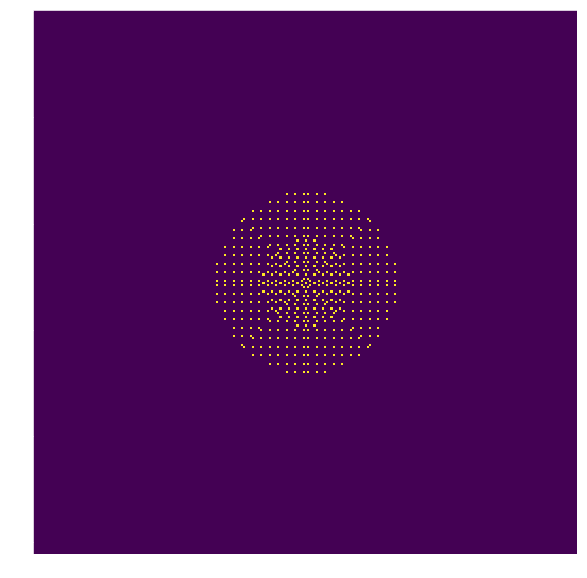

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(np.sum(Source,axis=0)))

In [9]:
# Microscope object generation

setup = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, n_media = n_media, illu_mode='Arbitrary', Source=Source)



In [10]:
I_meas, Stokes_out = setup.simulate_waveorder_inc_measurements(n_e, n_o, dz, mu_e, orientation, inclination)

Number of sources considered (51 / 51) in pattern (1 / 9), elapsed time: 0.97
Number of sources considered (51 / 51) in pattern (2 / 9), elapsed time: 1.90
Number of sources considered (51 / 51) in pattern (3 / 9), elapsed time: 2.83
Number of sources considered (51 / 51) in pattern (4 / 9), elapsed time: 3.75
Number of sources considered (51 / 51) in pattern (5 / 9), elapsed time: 4.72
Number of sources considered (51 / 51) in pattern (6 / 9), elapsed time: 5.66
Number of sources considered (51 / 51) in pattern (7 / 9), elapsed time: 6.59
Number of sources considered (51 / 51) in pattern (8 / 9), elapsed time: 7.53
Number of sources considered (89 / 89) in pattern (9 / 9), elapsed time: 9.14


In [11]:
wo.parallel_4D_viewer(np.transpose(Stokes_out/np.mean(Stokes_out[0,:,:,-1]),(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [12]:
# Add noise to the measurement

photon_count = 14000
ext_ratio    = 100
const_bg     = photon_count/(0.5*(1-np.cos(chi)))/ext_ratio

I_meas_noise = (np.random.poisson(I_meas/np.mean(I_meas) * photon_count + const_bg)).astype('float64')


# I_meas_noise = I_meas/np.mean(I_meas) * photon_count

In [13]:
wo.parallel_4D_viewer(np.transpose(Stokes_out/np.mean(Stokes_out[0]),(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [14]:
# Save simulations

f = open('simulation_data_phase_1_noise_scanned.pckl', 'wb')
pickle.dump((I_meas_noise, lambda_illu, n_media, ps, NA_obj, NA_illu, z_defocus, Source_cont, chi), f)
f.close()